# This notebook simulates a simple mountain destroyed by rainfall and glaciers


figured out that scipy zoom really makes the figures shine


## Principles:

* The land starts as rock

* Rain falls on a random set of figures at every step

* Rain flows downhill, and can barely scratch the rock, but drags the gravel along

* The temperature is determined by height

* Rain freezes to glacier if it's below zero

* Glaciers destroy the rock into gravel below them

* Glaciers flow downhill slowly

* When above zero, a glacier melts at a constant rate

# The goal is to beat the reference time of 1.3s for 100 flowsteps

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import njit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

import pickle

# Making a mountainside

In [2]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

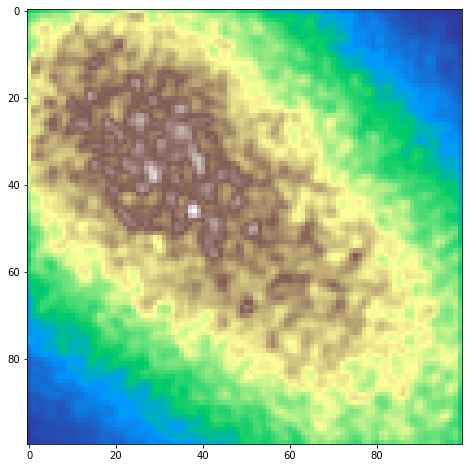

In [3]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2.e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**3. * lmax
land *= 3000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [4]:
zland = ndimage.zoom(land, 2)

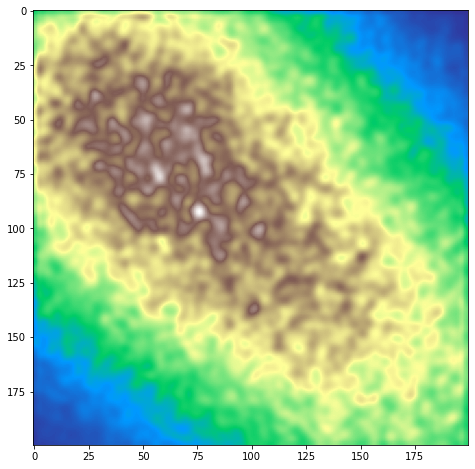

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [6]:
land.min()

145.54673989399592

# Erosion model of the mountain side

In [98]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

# @jit
def center_cut(arr):
    """This was tested to go fastest with numpy  """
    return arr[1:-1, 1:-1]

@njit
def null_edges(arr):
    """THis was tested to go from 1.2us to 557ns with numba"""
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [100]:
@jit
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
#             print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [101]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    @jit
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    @jit
    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, fraction=0.2, seed=10):
        """
        This is adds new rain water to the water canvas
    
        """
        self.layers = np.sort(("water",))
        self.key = "water"
        self.rainfall = rainfall
        self.fraction = fraction
        self.rng = np.random.RandomState(seed)
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        rmax = 100
        rpiv = rmax * (1 - self.fraction)
        rainmap = np.random.random(size=water_local.shape) * rmax
        rainmap[rainmap <= rpiv] = 0.
        rainmap[rainmap > rpiv] = self.rainfall
        
        water_local += rainmap
        
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        


In [102]:
   
class IceWaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4, flow_limit=10.,
                 ice_fracturing_rate=0.1, ice_melt_rate=0.05, ice_melt_min=40, ice_flow_rate=0.05,
                 ice_freeze_t=0, ice_melt_t=0,
                 temperature0=30, temperature_2k=0, h2k=3000.
                ):
        """
        This is a four component erosion model with glaciers
        
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water", "ice", "temperature"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.ikey = "ice"
        self.tkey = "temperature"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.ice_fracturing_rate = ice_fracturing_rate
        self.ice_melt_rate = ice_melt_rate
        self.ice_melt_min = ice_melt_min
        self.ice_flow_rate = ice_flow_rate
        self.altitude = altitude
        self.ice_freeze_t = ice_freeze_t
        self.ice_melt_t = ice_melt_t
        
        self.temperature0 = temperature0
        self.temperature_2k = temperature_2k
        self.h2k = h2k
        
    def get_temperature_map(self, height_local):
        res = (self.temperature_2k - self.temperature0) / self.h2k * height_local + self.temperature0
#         print(res)
        return res
    
    
    def freezing(self, ice, temp, water):
        """
        This is actually melting and freezing melting is negative freezing
        
        Ice has some time to melt, and to freeze,
        this is a self similar proportional process, with a minimum cutoff step
        """
        
        meltwater = np.zeros(ice.shape)
        newice = np.zeros(ice.shape)
        
        imelt = np.where(temp > self.ice_melt_t)
        ifreeze = np.where(temp < self.ice_freeze_t)
#         print(temp[imelt].mean())
#         print(temp[ifreeze].mean())
        
        meltwater[imelt] = ice[imelt] * self.ice_melt_rate
        ii = np.where(meltwater[imelt] < self.ice_melt_min)
        meltwater[imelt][ii] = ice[imelt][ii] # this cuts off the iteration process for melting graciers
        
        newice[ifreeze] = water[ifreeze] * self.ice_melt_rate
        ii = np.where(newice[ifreeze] < self.ice_melt_min)
        newice[ifreeze][ii] = water[ifreeze][ii] # this cuts off the iteration process for freezing glaciers        
        
        # This is just a two field component continuity equation
        ice += (newice - meltwater)
        water -= (newice - meltwater)
        
        return ice, water
        
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        water_local = cell.canvases[self.wkey]
        ice_local = cell.canvases[self.ikey]
        
        temp_height_local = rock_local + gravel_local
        temp_local = self.get_temperature_map(temp_height_local) # temperature is static, it matter locally only
        ice_local, water_local = self.freezing(ice_local, temp_local, water_local)
        
        water_shifted = cell.shifted_canvases[self.wkey]
        ice_shifted = cell.shifted_canvases[self.ikey]
        
        height_local = rock_local + gravel_local + water_local + ice_local
        height_shifted = rock_shifted + gravel_shifted + water_shifted + ice_shifted

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # and now we tag on glaciers to erode the bedrock into gravel, and flow
        outflow_i = ice_local * fractions * self.ice_flow_rate
        ice_local = self.calc_flows(ice_local, outflow_i, cell)
        ice_local = null_edges(ice_local)       # a glacier simply flows out of the frame and goes away to the distance 
        
        
        # 2) the gravel flows
        gflow_limit = np.sqrt(gravel_local) * self.drag_coeff * self.gravel_factor
        ii = np.where(gflow_limit > 0.1 * gravel_local)
        gflow_limit[ii] = 0.1 * gravel_local[ii]        
        gflow_limit = np.array([gflow_limit, ] * 4) / 4.
        outflow_g = (outflow_w + outflow_i) * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        # 3) The rock erodes from water and ice flow
        # we have to establish the local gravel coverage
        # The rock is eroded into gravel by the flow of water and ice
        lflow_limit = np.sqrt(rock_local) * self.drag_coeff
        ii = np.where(lflow_limit > 0.1 * rock_local)
        lflow_limit[ii] = 0.1 * rock_local[ii]
        ii = np.where(gravel_local > 0)
        lflow_limit[ii] = 0. # This means the rock will never erode if its covered by gravel,
        # the gravel has to flow away first in order to occur
        lflow_limit = np.array([lflow_limit, ] * 4) / 4.
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        # in megaoutflow, water can pile up really high, this must be regularized
        outflow_l = outflow_w * self.land_coerosion_rate # this is water
        outflow_l += outflow_i * self.ice_fracturing_rate # This is ice
        ii = outflow_l > (lflow_limit)
        outflow_l[ii] = lflow_limit[ii]        
        
        rock_local -= outflow_l.sum(axis=0)    
        gravel_local += self._calc_flows(gravel_local, outflow_l, cell)
        

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local,
                        self.ikey: ice_local, self.tkey: temp_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    


In [103]:
rules = (
    RainFall(rainfall=0.02, fraction=0.25),
    IceWaterGravelFlow(land_coerosion_rate=0.05, water_flow_rate=0.9, drag_coeff=4, gravel_factor=10,
                       ice_fracturing_rate=0.2, ice_melt_rate=0.3, ice_melt_min=10, ice_flow_rate=0.1,
                       temperature0=24, temperature_2k=0, h2k=2500
                  ),
)
wmap = np.zeros(shape=zland.shape)
gmap = np.zeros(shape=zland.shape)
imap = np.zeros(shape=zland.shape)
tmap = np.zeros(shape=zland.shape) + 20.
initial_maps = {
    "rock": null_edges(zland * 0.8),
    "gravel": null_edges(zland * 0.2),
    "water": null_edges(wmap),
    "ice": null_edges(imap),
    "temperature": null_edges(tmap),
}

In [104]:
def test():
    cs = CellSpace(initial_maps, rules)
    cs.flow(100, savestep=100)

#     all_rock = copy.deepcopy(cs.maps["rock"])
#     all_gravel = copy.deepcopy(cs.maps["gravel"])
#     all_waters = copy.deepcopy(cs.maps["water"])
#     all_ice = copy.deepcopy(cs.maps["ice"])
#     all_temperature = copy.deepcopy(cs.maps["temperature"])

In [105]:
%timeit test()

/tmp/ipykernel_17562/523794019.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pad" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_17562/523794019.py (4)

File "../../../../../../tmp/ipykernel_17562/523794019.py", line 4:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_17562/523794019.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "pad" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../tmp/ipykernel_17562/523794019.py", line 6:
<source missing, REPL/exec in use?>

  @jit
/home/vtn/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "pad" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../../../tmp/ipykernel_17562/523794019.py", line 4:
<so

1.39 s ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
len(zland.flatten())

40000